In [1]:
import re
import numpy as np
import pandas as pd
import scipy.cluster
import scipy.spatial
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('../peptidome.mplstyle')

import sys
sys.path.append('..')
from lib import *

datadir = '/home/amayer/lptcloud/data/viraldbs/'


In [2]:
filepath = datadir + 'FluA_H1N1_2009-2019.fasta'

In [3]:
headers, seqs = list(zip(*[(h,s) for h,s in fasta_iter(filepath, returndescription=True, returnheader=False)]))


In [4]:
dfmeta = pd.DataFrame(dict(header=headers, seq=seqs))

In [25]:
columns = ['Isolate name', 'Isolate ID', 'Type', 'Gene name', 'Collection date', 'Passage details/history']
for i, column in enumerate(columns):
    dfmeta[column] = dfmeta['header'].apply(lambda x: x.split('|')[i])

In [34]:
len(dfmeta['Gene name'].value_counts())

11

In [56]:
dfs = []
for seq in np.random.choice(seqs, 100, replace=False):
    counter = Counter([seq], k=1)
    dfs.append(counter.to_df())

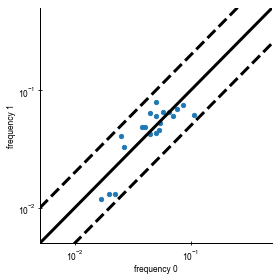

In [57]:
#df0, df1 = dfs[0], dfs[200]
df0, df1 = dfs[0], dfs[2]
dfmerged = pd.merge(df0, df1, on='seq', suffixes=['_0', '_1'])
fig, ax = plt.subplots(figsize=(4, 4))
xmin, xmax = 0.5e-2, 5e-1
x = np.logspace(np.log10(xmin), np.log10(xmax))
ax.plot(x, x, 'k', lw=3)
ax.plot(x, x*2, '--k', lw=3)
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)
ax.plot(x, x/2, '--k', lw=3)
dfmerged.plot(x='freq_0', y='freq_1', kind='scatter', logx=True, logy=True, ax=ax);
ax.set_xlabel('frequency 0')
ax.set_ylabel('frequency 1')
fig.tight_layout()


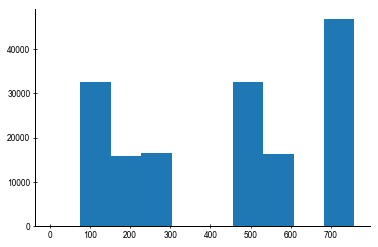

In [12]:
lens = [len(seq) for seq in seqs]
plt.hist(lens);

In [54]:
seqs_isolate = [list(dfg['seq']) for name, dfg in dfmeta.groupby('Isolate name') if len(dfg) == 10]

In [64]:
dfs = []
for i in np.random.choice(np.arange(0, len(seqs_isolate)), 100, replace=False):
    seq = seqs_isolate[i]
    counter = Counter(seq, k=2)
    dfs.append(counter.to_df(norm=False))

In [65]:
pseudocount = 1.0
names = np.arange(0, len(dfs))
N = len(names)
distances_uniform = np.zeros(N)
distances = np.zeros((N, N))
for i, namei in enumerate(names):
    df1 = dfs[namei]
    f1 = np.asarray(list(df1['count']))
    f1 += pseudocount*np.ones_like(f1)
    f2 = pseudocount*np.ones_like(f1)
    distances_uniform[i] = calc_jsd(f1, f2)
    for j, namej in enumerate(names):
        df2 = dfs[namej]
        dfm = pd.merge(df1, df2, on='seq', suffixes=['_1', '_2'])
        f1, f2 = np.asarray(dfm['count_1']), np.asarray(dfm['count_2'])
        f1 += pseudocount*np.ones_like(f1)
        f2 += pseudocount*np.ones_like(f2)
        distances[i, j] = calc_jsd(f1, f2, base=2)


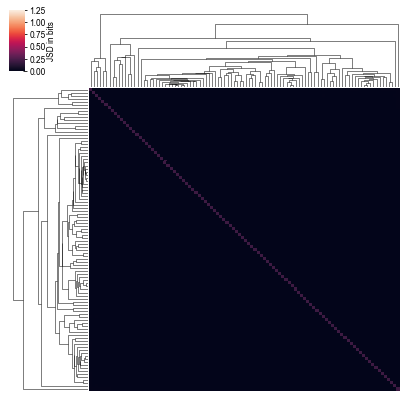

In [76]:
cond_distances = scipy.spatial.distance.squareform(0.5*(distances+distances.T))
Z = scipy.cluster.hierarchy.linkage(cond_distances, method='average', optimal_ordering=True)
heatmap = distances.copy()
for i in range(heatmap.shape[0]):
    heatmap[i, i] = distances_uniform[i]
cg = sns.clustermap(heatmap*4.5, vmin=0.0, vmax=1.25, row_linkage=Z, col_linkage=Z, cbar_kws=dict(label='JSD in bits'), figsize=(7, 7))
cg.ax_heatmap.set_xticks([])
cg.ax_heatmap.set_yticks([])
plt.savefig('main.png')
